<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/FII_percentile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install pyotp --q
!pip install smartapi-python==1.4.1 --q
!pip install logzero --q


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [28]:
# package import statement
from SmartApi import SmartConnect #or from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger
import time
import os
import urllib
import json
import pandas as pd
import datetime as dt

api_key = 'xOHnB7MG'
username = 'M55123447'
pwd = '1471'
smartApi = SmartConnect(api_key)
try:
    token = "GJZACUQI2TTAIBHBA34XNFJURQ"
    totp = pyotp.TOTP(token).now()
except Exception as e:
    logger.error("Invalid Token: The provided token is not valid.")
    raise e

correlation_id = "abcde"
data = smartApi.generateSession(username, pwd, totp)

if data['status'] == False:
    logger.error(data)

else:
    # login api call
    # logger.info(f"You Credentials: {data}")
    authToken = data['data']['jwtToken']
    refreshToken = data['data']['refreshToken']
    # fetch the feedtoken
    feedToken = smartApi.getfeedToken()
    # fetch User Profile
    res = smartApi.getProfile(refreshToken)
    smartApi.generateToken(refreshToken)
    res=res['data']['exchanges']


#Download Nifty50 Index Data
params = {
           "exchange": "NSE",
           "symboltoken": '99926000',
           "interval": "ONE_DAY",
           "fromdate": (dt.datetime(2019, 3, 7).strftime('%Y-%m-%d %H:%M')),
           "todate": (dt.datetime.today().strftime('%Y-%m-%d %H:%M'))
         }
nifty_data = smartApi.getCandleData(params)
nifty_data_format= pd.DataFrame(nifty_data["data"],
                               columns = ["Date","Open","High","Low","Close","Volume"])
nifty_data_format.set_index("Date",inplace=True)
nifty_data_format.index = pd.to_datetime(nifty_data_format.index)
nifty_data_format.index = nifty_data_format.index.tz_localize(None)



In [29]:
content_path='https://raw.githubusercontent.com/anirbanghoshsbi/data/main/'
def read_data_file(file_name, content_path):
    return pd.read_csv(content_path + file_name, sep='/t' , header=None)

def read_and_combine_data_files(file_names, content_path):
    combined_data = []

    for file_name in file_names:
        data = read_data_file(file_name, content_path)
        combined_data.extend(data[0].tolist())

    return combined_data

def create_dataframe_from_list(data, group_size):
    df = pd.DataFrame(columns=range(group_size)) # Create an empty DataFrame with columns
    for i in range(0, len(data), group_size):
        df.loc[len(df)] = data[i:i + group_size] # Add rows using loc
    return df


file_names = [f'fii{i}.txt' for i in range(1, 9)]
group_size = 7

data = read_and_combine_data_files(file_names, content_path)
df = create_dataframe_from_list(data, group_size)
df.to_csv('fii.csv')

fii_fig = pd.read_csv('/content/fii.csv')
fii = fii_fig.copy()

fii_fig = fii_fig[::-1]
fii_fig.columns = ['Index', 'Date', 'FIIcall', 'FIIput', 'FIIFuture', 'FIIFutOI', 'FIICash', 'DIIcash']
fii_fig.drop('Index',inplace=True,axis=1)
fii_fig['Date']=pd.to_datetime(fii_fig['Date'],format='%d %b %Y')
#nif['Date']=pd.to_datetime(nif['Date'],format='%Y-%m-%d').dt.tz_localize(None)
#fii_fig=fii_fig.set_index('Date')

In [38]:
fii_fig=fii_fig.tail(500)

In [39]:
nifty_data_format=nifty_data_format.tail(500)

In [40]:
nifty_data_format= nifty_data_format.tail(len(fii_fig))

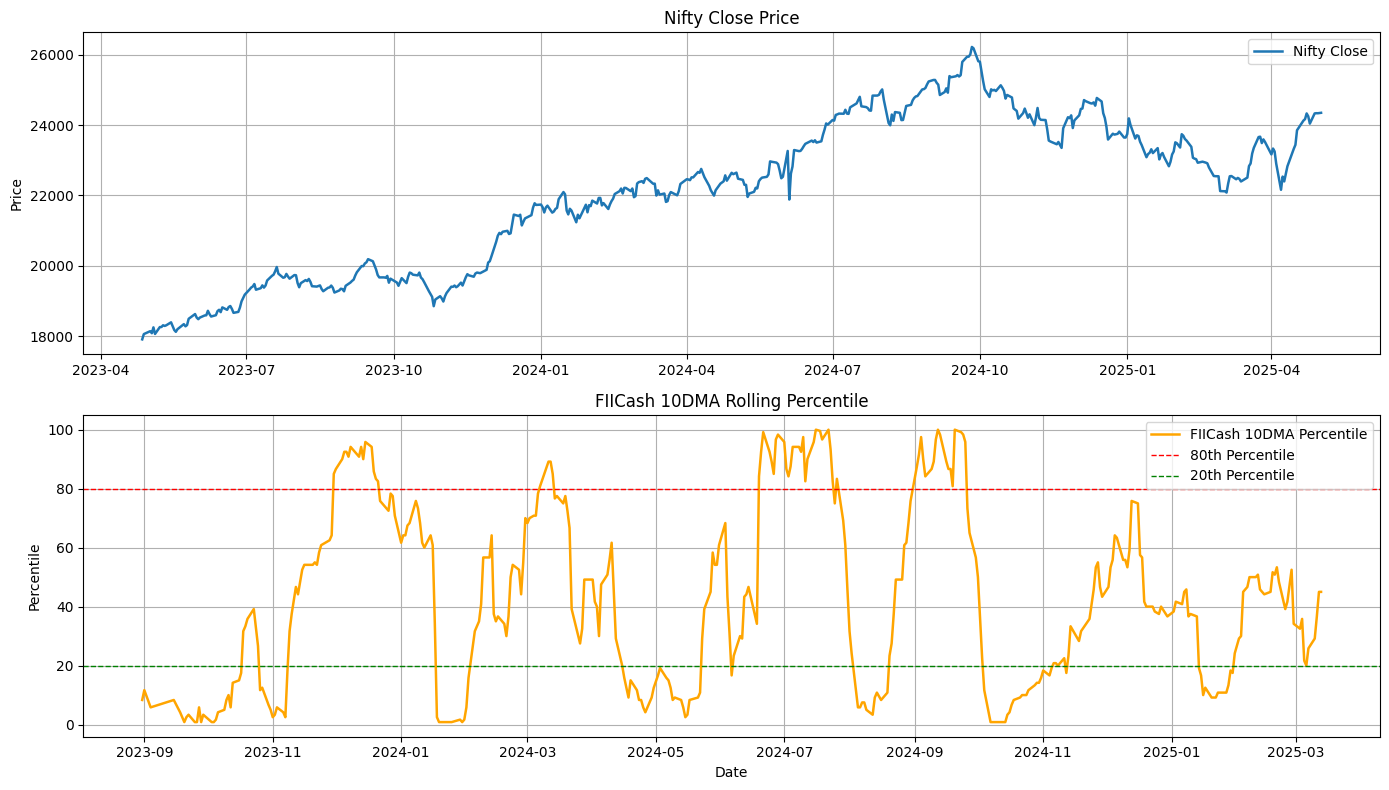

In [41]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Ensure fii_fig['Date'] is datetime
fii_fig['Date'] = pd.to_datetime(fii_fig['Date'])


# Step 4: Calculate 10-day moving average of FIICash
fii_fig['FIICash_10DMA'] = fii_fig['FIICash'].rolling(window=10).mean()

# Step 5: Compute 120-day rolling percentile of FIICash 10DMA
def rolling_percentile(series, window):
    return series.rolling(window).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1] * 100, raw=False)

fii_fig['FIICash_10DMA_percentile'] = rolling_percentile(fii_fig['FIICash_10DMA'], window=120)

# Step 6: Drop rows with NaNs from rolling
plot_data = fii_fig.dropna(subset=['FIICash_10DMA_percentile'])

# Step 7: Plotting
plt.figure(figsize=(14, 8))

# Subplot 1: Nifty Close
plt.subplot(2, 1, 1)
plt.plot(nifty_data_format['Close'], label='Nifty Close', linewidth=1.8)
plt.title("Nifty Close Price")
plt.ylabel("Price")
plt.grid(True)
plt.legend()

# Subplot 2: FIICash 10DMA Percentile
plt.subplot(2, 1, 2)
plt.plot(plot_data['Date'], plot_data['FIICash_10DMA_percentile'], label='FIICash 10DMA Percentile', color='orange', linewidth=1.8)
plt.axhline(80, color='red', linestyle='--', linewidth=1, label='80th Percentile')
plt.axhline(20, color='green', linestyle='--', linewidth=1, label='20th Percentile')
plt.title("FIICash 10DMA Rolling Percentile")
plt.ylabel("Percentile")
plt.xlabel("Date")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Calculate 10-day moving average of FIICash

fii_fig['FIICash_Standardized'] = scaler.fit_transform(fii_fig[['FIICash']])
fii_fig['FIICash_MA10'] = fii_fig['FIICash_Standardized'].rolling(window=20, min_periods=1).mean()
# Function to calculate rolling percentile
def rolling_percentile(series, window):
    return series.rolling(window=window, min_periods=1).apply(lambda x: np.percentile(x, (x.rank(pct=True) * 100).iloc[-1]))

# Calculate rolling percentile (0-100) for the 10-day moving average
fii_fig['FIICash_MA10_Percentile'] = fii_fig['FIICash_MA10'].rolling(window=50, min_periods=1).apply(lambda x: (x.rank(pct=True).iloc[-1]) * 100)
# Function to calculate rolling z-score
def rolling_zscore(series, window):
    return (series - series.rolling(window=window, min_periods=1).mean()) / series.rolling(window=window, min_periods=1).std()

# Calculate rolling z-score for the 10-day moving average
fii_fig['FIICash_MA10_ZScore'] = rolling_zscore(fii_fig['FIICash_MA10'], window=20)


In [43]:
'''
fii_fig=fii_fig.set_index('Date')
nif.set_index('Date',inplace=True)
# download nifty price and concat with fii data
fii_fig=fii_fig.join(nif)
'''

"\nfii_fig=fii_fig.set_index('Date')\nnif.set_index('Date',inplace=True)\n# download nifty price and concat with fii data\nfii_fig=fii_fig.join(nif)\n"

In [44]:
fii_fig=fii_fig.tail(1500)

In [45]:
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming 'fii_fig' is already defined
scaler = StandardScaler()
fii_fig['FIICash_Standardized'] = scaler.fit_transform(fii_fig[['FIICash']])

# Calculating 10-day moving average
fii_fig['FIICash_10DMA'] = fii_fig['FIICash_Standardized'].rolling(window=10).mean()

# Plotting
# Create subplots
fig, ax1 = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
ax1[1].plot( fii_fig['FIICash_Standardized'], label='FIICash Standardized', alpha=0.5)
ax1[1].plot( fii_fig['FIICash_10DMA'], label='10-Day Moving Average', linewidth=2, color='red')
ax1[1].set_ylabel('Standardized FIICash')
ax1[1].set_title('FIICash Standardized & 10-Day Moving Average')
ax1[1].legend()
ax1[1].grid()

# Plot Close price
ax1[2].plot( fii_fig['Close'], label='Close Price', color='red')
ax1[2].set_xlabel('Date')
ax1[2].set_ylabel('Close Price')
ax1[2].set_title('Stock Close Price')
ax1[2].legend()
ax1[2].grid()

plt.show()
'''

"\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.preprocessing import StandardScaler\n\n# Assuming 'fii_fig' is already defined\nscaler = StandardScaler()\nfii_fig['FIICash_Standardized'] = scaler.fit_transform(fii_fig[['FIICash']])\n\n# Calculating 10-day moving average\nfii_fig['FIICash_10DMA'] = fii_fig['FIICash_Standardized'].rolling(window=10).mean()\n\n# Plotting\n# Create subplots\nfig, ax1 = plt.subplots(3, 1, figsize=(12, 8), sharex=True)\nax1[1].plot( fii_fig['FIICash_Standardized'], label='FIICash Standardized', alpha=0.5)\nax1[1].plot( fii_fig['FIICash_10DMA'], label='10-Day Moving Average', linewidth=2, color='red')\nax1[1].set_ylabel('Standardized FIICash')\nax1[1].set_title('FIICash Standardized & 10-Day Moving Average')\nax1[1].legend()\nax1[1].grid()\n\n# Plot Close price\nax1[2].plot( fii_fig['Close'], label='Close Price', color='red')\nax1[2].set_xlabel('Date')\nax1[2].set_ylabel('Close Price')\nax1[2].set_title('Stock Close P

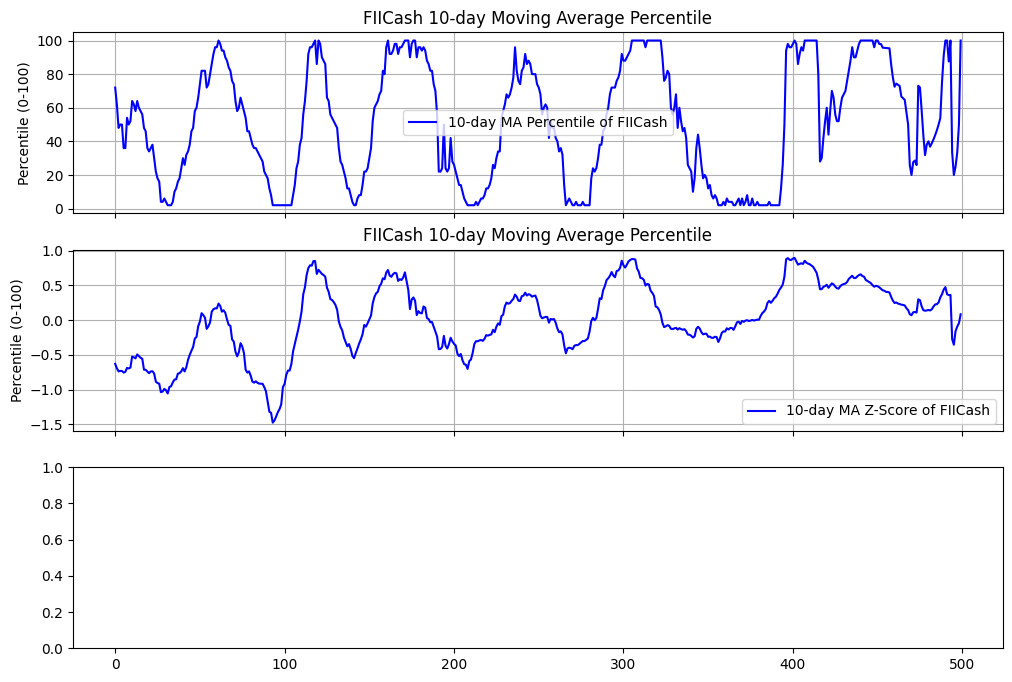

In [46]:
# Create subplots
fig, ax1 = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Plot FIICash_MA10_Percentile
ax1[0].plot(fii_fig['FIICash_MA10_Percentile'], label='10-day MA Percentile of FIICash', color='blue')
ax1[0].set_ylabel('Percentile (0-100)')
ax1[0].set_title('FIICash 10-day Moving Average Percentile')
ax1[0].legend()
ax1[0].grid()

# Plot FIICash_MA10_Percentile
ax1[1].plot(fii_fig['FIICash_MA10'], label='10-day MA Z-Score of FIICash', color='blue')
ax1[1].set_ylabel('Percentile (0-100)')
ax1[1].set_title('FIICash 10-day Moving Average Percentile')
ax1[1].legend()
ax1[1].grid()
'''
# Plot Close price
ax1[2].plot( fii_fig['Close'], label='Close Price', color='red')
ax1[2].set_xlabel('Date')
ax1[2].set_ylabel('Close Price')
ax1[2].set_title('Stock Close Price')
ax1[2].legend()
ax1[2].grid()
'''
plt.show()

<Axes: >

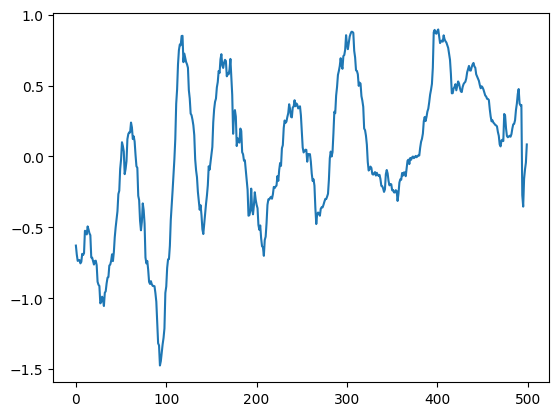

In [47]:
fii_fig['FIICash_MA10'].plot()

In [48]:
from matplotlib import pyplot as plt
_df_8['FIICash_MA10'].plot(kind='line', figsize=(8, 4), title='FIICash_MA10')
plt.gca().spines[['top', 'right']].set_visible(False)

NameError: name '_df_8' is not defined